# Linear programming

## LP in scipy

In [ ]:
from scipy.optimize import linprog

$$
\begin{align*}
&\min_x c^{\top}x \\
\text{s.t. } & Ax \leq b\\
x_2 \geq -3, \qquad &A = \begin{pmatrix}
    -3       & 1\\
    1      & 2
\end{pmatrix} \qquad b = \begin{pmatrix} 6 \\ 4\end{pmatrix}
\end{align*}
$$

In [ ]:
c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True})

print(res)

If you want to build tableaus quickly 😀

In [ ]:
import scipy

c = [-1, 4]
A = [[-3, 1], [1, 2]]
b = [6, 4]
x0_bounds = (None, None)
x1_bounds = (-3, None)
from scipy.optimize import linprog
res = linprog(c, A_ub=A, b_ub=b, bounds=(x0_bounds, x1_bounds),
              options={"disp": True}, callback=scipy.optimize.linprog_verbose_callback)

## Klee, Minty example, when simplex works slow

In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import linprog
import seaborn as sns
sns.set()

def generate_KleeMinty_test_problem(n):
    c = np.array([2**i for i in range(n)])
    c = c[::-1]
    bounds = [(0, None) for i in range(n)]
    b = np.array([5**(i+1) for i in range(n)])
    a = np.array([1] + [2**(i+1) for i in range(1, n)])
    A = np.zeros((n, n))
    for i in range(n):
        A[i:, i] = a[:n-i]
    return -c, A, b, bounds

def generate_random_LP_problem(n):
    c = np.random.rand(n)
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    bounds = []
    for i in range(n):
        bound = (-np.random.rand(1), np.random.rand(1))
        bounds.append(bound)
    return c, A, b, bounds

In [4]:
n = 5
c, A, b, bounds = generate_KleeMinty_test_problem(n)
print(c)
print(A) 
print(b)
print(bounds)

[-16  -8  -4  -2  -1]
[[ 1.  0.  0.  0.  0.]
 [ 4.  1.  0.  0.  0.]
 [ 8.  4.  1.  0.  0.]
 [16.  8.  4.  1.  0.]
 [32. 16.  8.  4.  1.]]
[   5   25  125  625 3125]
[(0, None), (0, None), (0, None), (0, None), (0, None)]


2.96 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.97 ms ± 51.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.76 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.53 ms ± 77.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.98 ms ± 40.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.55 ms ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.41 ms ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.27 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.53 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.63 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.67 ms ± 694 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.05 ms ± 86.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.59 ms ± 349 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.21 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 1

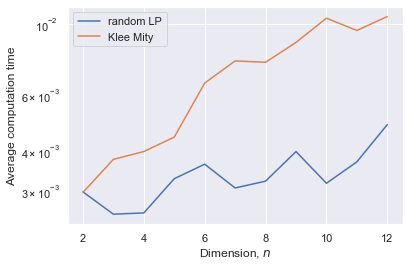

In [22]:
n_list = range(2, 13)

n_iters_km = np.zeros(len(n_list))
times_km   = np.zeros(len(n_list))
n_iters_r  = np.zeros(len(n_list))
times_r    = np.zeros(len(n_list))

for i, n in enumerate(n_list):
    c, A, b, bounds = generate_KleeMinty_test_problem(n)
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 1000 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1})
    n_iters_km[i] = res.nit
    times_km[i] = time.average

    c, A, b, bounds = generate_random_LP_problem(n)
    res = linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list)})
    time = %timeit -o -n 1000 linprog(c, A, b, bounds=bounds, options={"maxiter": 2**max(n_list) + 1})
    n_iters_r[i] = res.nit
    times_r[i] = time.average

plt.semilogy(n_list, times_r, label='random LP')
plt.semilogy(n_list, times_km, label = 'Klee Mity')
plt.legend()
plt.xlabel("Dimension, $n$")
plt.ylabel("Average computation time")
plt.show()

## PuLP library example (Optimal watching TED talks)

In [23]:
!pip install pulp

In [78]:
%matplotlib inline
 
import pulp
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from IPython.display import Image

In [79]:
# Download the dataset from https://www.kaggle.com/rounakbanik/ted-talks

# Read the dataset into pandas dataframe, convert duration from seconds to minutes
ted = pd.read_csv('./ted_main.csv', encoding='ISO-8859-1')
ted['duration'] = ted['duration'] / 60
ted = ted.round({'duration': 1})

# Select subset of columns & rows (if required)
# data = ted.sample(n=1000) # 'n' can be changed as required
data = ted
selected_cols = ['name', 'event', 'duration', 'views']
data.reset_index(inplace=True)
data.head()

,index,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,19.4,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,1,265,With the same humor and humanity he exuded in ...,16.3,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,2,124,New York Times columnist David Pogue takes aim...,21.4,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,3,200,"In an emotionally charged talk, MacArthur-winn...",18.6,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,4,593,You've never seen data presented like this. Wi...,19.8,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [93]:
# create LP object,
# set up as a maximization problem --> since we want to maximize the number of TED talks to watch
prob = pulp.LpProblem('WatchingTEDTalks', pulp.LpMaximize)

In [94]:
# create decision - yes or no to watch the talk?
decision_variables = []
for rownum, row in data.iterrows():
    variable = str('x' + str(row['index']))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat = 'Integer') # make variable binary
    decision_variables.append(variable)
    
print('Total number of decision variables: ' + str(len(decision_variables)))

Total number of decision variables: 2550


In [95]:
# Create optimization Function
total_views = ''
for rownum, row in data.iterrows():
    for i,talk in enumerate(decision_variables):
        if rownum == i:
            formula = row['views'] * talk
            total_views += formula
            
prob += total_views
# print('Optimization function: ' + str(total_views))

In [96]:
# Contraints
total_time_available_for_talks = 3*60 # Total time available is 10 hours . Converted to minutes
total_talks_can_watch = 8 # Don't want an overload information

In [97]:
# Create Constraint 1 - Time for talks
total_time_talks = ''
for rownum, row in data.iterrows():
    for i,  talk in enumerate(decision_variables):
        if rownum == i:
            formula = row['duration']*talk
            total_time_talks += formula
            
prob += (total_time_talks <= total_time_available_for_talks)

In [98]:
# Create Constraint 2 - Number of talks
total_talks = ''

for rownum, row in data.iterrows():
    for i, talk in enumerate(decision_variables):
        if rownum == i:
            formula = talk
            total_talks += formula
            
prob += (total_talks == total_talks_can_watch)

In [99]:
# Be careful, the output will be huge
# print(prob)
prob.writeLP('WatchingTEDTalks.lp')
print('🤔 The problem has successfully formulated')

🤔 The problem has successfully formulated


In [100]:
optimization_result = prob.solve()

assert optimization_result == pulp.LpStatusOptimal
print('Status:', pulp.LpStatus[prob.status])
print('Optimal Solution to the problem: ', pulp.value(prob.objective))
print('Individual decision variables: ')


for v in prob.variables():
    if v.varValue > 0:
        print(v.name, '=', v.varValue)

Status: Optimal
Optimal Solution to the problem:  241601896.0
Individual decision variables: 
x0 = 1.0
x1346 = 1.0
x1776 = 1.0
x201 = 1.0
x452 = 1.0
x5 = 1.0
x677 = 1.0
x837 = 1.0


In [101]:
# reorder results
variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)
    
df = pd.DataFrame({'index': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['index'])
    df.loc[rownum, 'index'] = int(value[0])
    
# df = df.sort_index(by = 'index')
df = df.sort_values(by = 'index')
result = pd.merge(data, df, on = 'index')
result = result[result['value'] == 1].sort_values(by = 'views', ascending = False)
selected_cols_final = ['name', 'event', 'duration', 'views']
final_set_of_talks_to_watch = result[selected_cols_final]

In [102]:
from IPython.display import display, HTML
display(HTML(final_set_of_talks_to_watch.to_html(index=False)))

name,event,duration,views
Ken Robinson: Do schools kill creativity?,TED2006,19.4,47227110
Amy Cuddy: Your body language may shape who you are,TEDGlobal 2012,21.0,43155405
Simon Sinek: How great leaders inspire action,TEDxPuget Sound,18.1,34309432
BrenÃ© Brown: The power of vulnerability,TEDxHouston,20.3,31168150
Mary Roach: 10 things you didn't know about orgasm,TED2009,16.7,22270883
Julian Treasure: How to speak so that people want to listen,TEDGlobal 2013,10.0,21594632
Jill Bolte Taylor: My stroke of insight,TED2008,18.3,21190883
Tony Robbins: Why we do what we do,TED2006,21.8,20685401
